In [1]:
import numpy as np
import cv2 as cv
import  matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
img1 = cv.imread('morpheus_L_rectified.png',0)
img2 = cv.imread('morpheus_R_rectified.png',0)

# img1 = img1[:,:,0]
# img2 = img2[:,:,0]

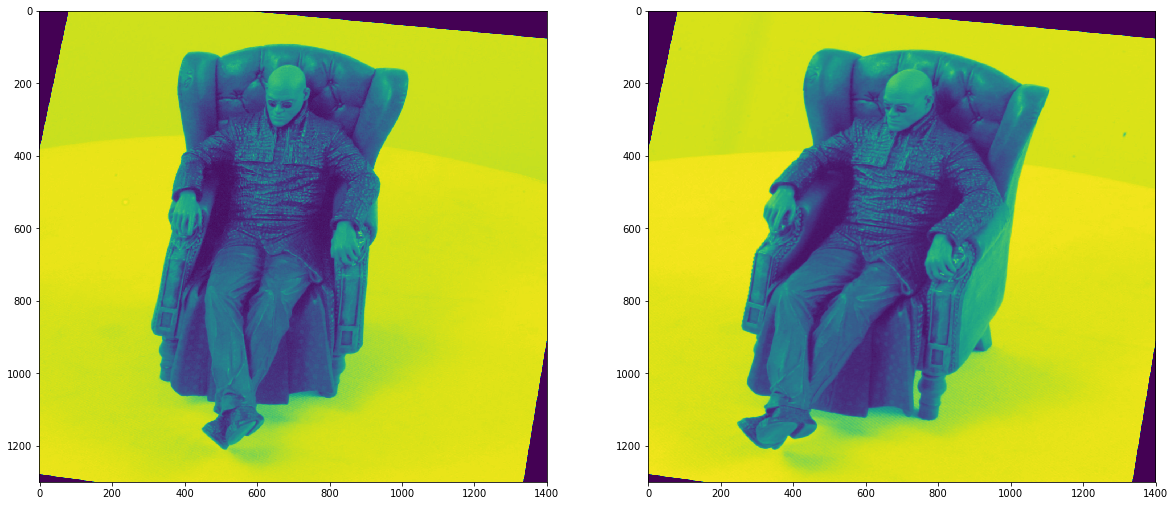

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show()

In [4]:
# good values: 20, 30, 60, 90

# best params for channel 0
num_disparities = 29

In [5]:
img1 = cv.copyMakeBorder(img1,0,0,num_disparities,0,cv.BORDER_CONSTANT)
img2 = cv.copyMakeBorder(img2,0,0,num_disparities,0,cv.BORDER_CONSTANT)

## First experiment

computing disparity...


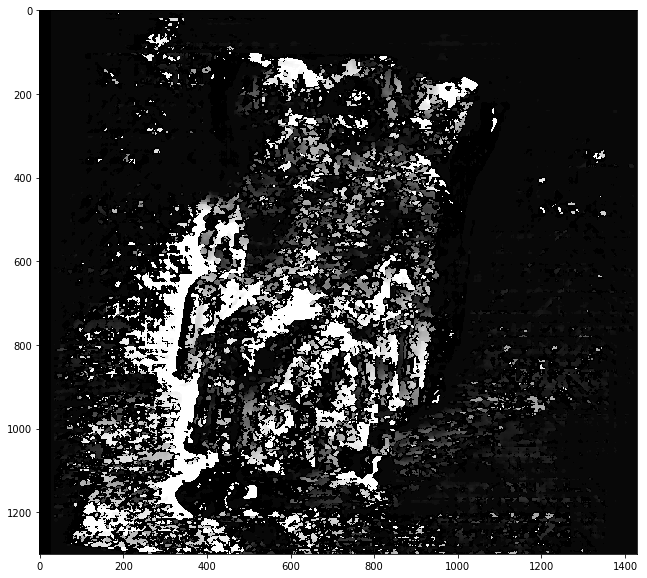

In [6]:
window_size = 5
min_disp = 0

stereo = cv.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disparities,
    blockSize = 8,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 15,
    speckleWindowSize = 0,
    speckleRange = 2,
    mode=cv.STEREO_SGBM_MODE_SGBM
)

print('computing disparity...')
disp = stereo.compute(img1, img2)
norm_disp = (disp-min_disp)/num_disparities

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(norm_disp,'gray')

plt.show()

## Second method using 'mode 3way' + disparity map post-filtering

In [7]:
window_size = 3
 
left_matcher = cv.StereoSGBM_create(
    minDisparity=0,
    numDisparities=num_disparities,             
    blockSize=6,
    P1=8 * 3 * window_size ** 2,    
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=2,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv.ximgproc.createRightMatcher(left_matcher)

In [8]:
print('computing disparity...')
displ = left_matcher.compute(img1, img2)
dispr = right_matcher.compute(img2, img1)
displ = np.int16(displ)
dispr = np.int16(dispr)

computing disparity...


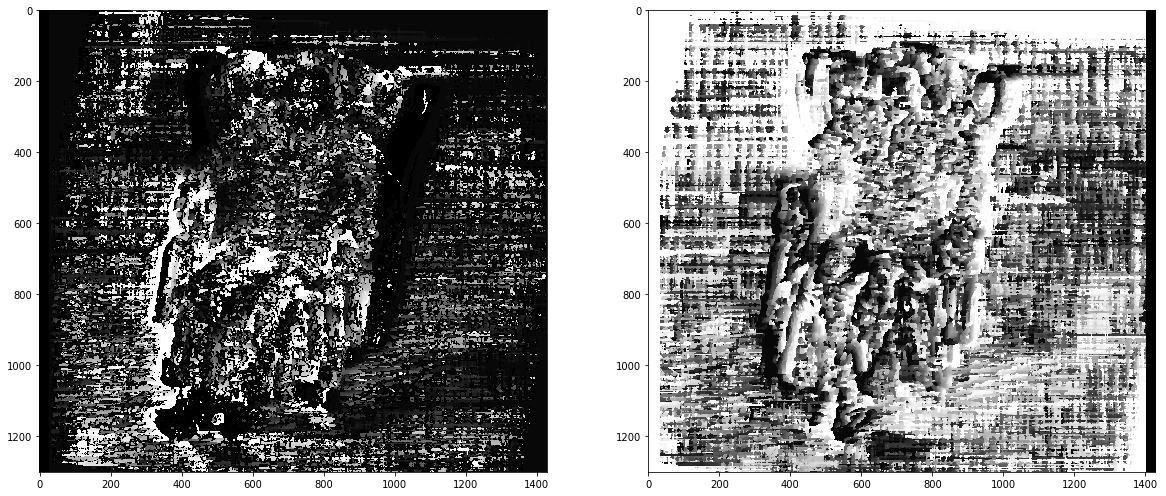

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(121),plt.imshow(displ,'gray')
plt.subplot(122),plt.imshow(dispr,'gray')
plt.show()

## Apply WLS filter

In [10]:
##Best params for channel 0
# lmbda = 160000
# sigma = 1.4

lmbda = 160000
sigma = 1.3

wls_filter = cv.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

In [11]:
filteredImg = wls_filter.filter(displ, img1, None, dispr)
# filteredImg = filteredImg/16

## removes padded columns

In [12]:
filteredImg = filteredImg[:,num_disparities:]
filteredImg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

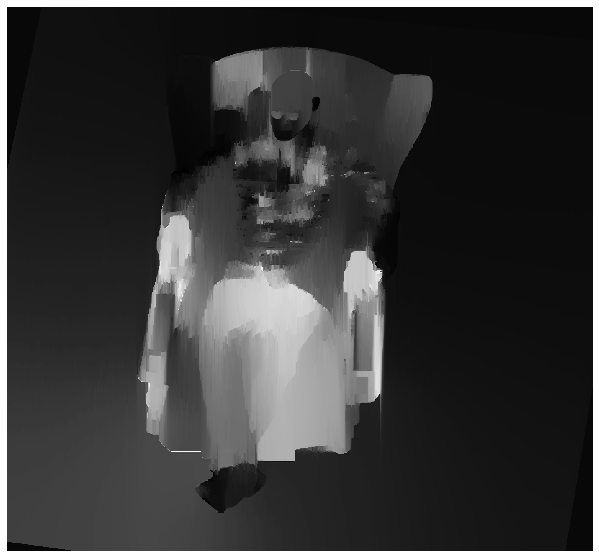

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.axis('off')


# gray = cm.gray
# m = cm.ScalarMappable(cmap=gray)
# m.set_array([filteredImg.min(),filteredImg.max()])
# plt.colorbar(m, ax=ax)

plt.imshow(filteredImg, 'gray')
plt.show()

### Computes depth map 

In [14]:
# Z = baseline * f / (d + doffs)
t_1 = np.array([ -532.285900 , 207.183600 , 2977.408000 ])
t_2 = np.array([ -614.549000 , 193.240700 , 3242.754000 ])
baseline = np.linalg.norm(t_1 - t_2)
baseline

278.1548521921198

In [15]:
principal_point = [ 738.251932, 457.560286 ]
doffs = principal_point[0] - principal_point[1]
doffs

280.691646

In [16]:
f = 6704.926882

In [17]:
filteredImg_2 = filteredImg + doffs
filteredImg_2 = baseline * f / filteredImg_2

In [18]:
filteredImg_2 = filteredImg_2/10

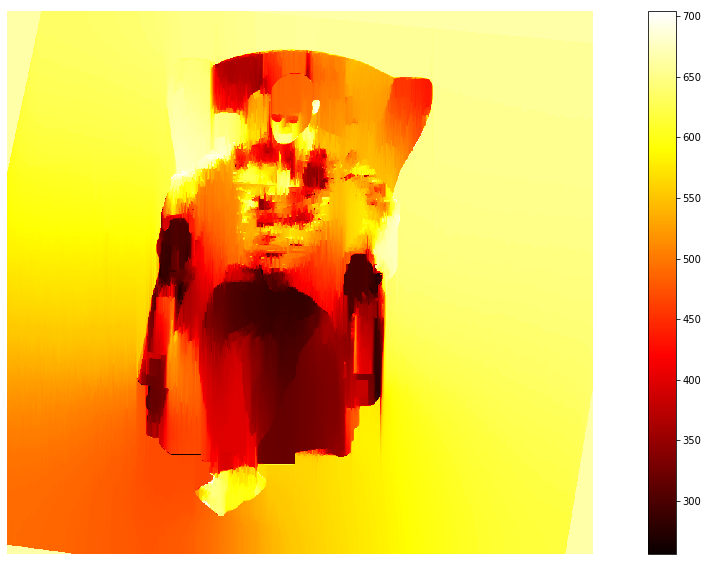

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.axis('off')

#filteredImg_2 = cv.normalize(src=filteredImg_2, dst=filteredImg_2, beta=0, alpha=254, norm_type=cv.NORM_MINMAX);
#filteredImg_2 = np.uint8(filteredImg_2)

hot = cm.hot
m = cm.ScalarMappable(cmap=hot)
m.set_array([filteredImg_2.min(),filteredImg_2.max()])
plt.colorbar(m, ax=ax)

plt.imshow(filteredImg_2, 'hot')
plt.show()